In [ ]:
!pip install python-graphblas

In [3]:
import graphblas as gb
import numpy as np
import matplotlib.pyplot as plt
from graphblas import Matrix, dtypes, binary, semiring, Vector
from graphblas.io import mmread

## Задача 1

*   Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford).
*   Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').


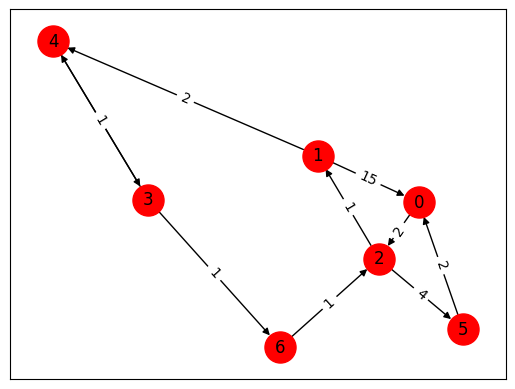

In [149]:
edges = [
    [2, 4, 1, 0, 3, 2, 3, 5, 6, 1],
    [1, 3, 0, 2, 4, 5, 6, 0, 2, 4],
    [1, 1, 15, 2, 1, 4, 1, 2, 1, 2],
]

A = Matrix.from_coo(edges[0], edges[1], edges[2])
gb.viz.draw(A)

In [78]:
def bellman_ford(graph, start_vertex):
    num_vertices = graph.nrows
    distances = Vector(graph.dtype, graph.nrows)
    distances[start_vertex] << 0

    for _ in range(num_vertices - 1):
        previous_distances = distances.dup()
        distances(binary.min) << distances.vxm(graph, semiring.min_plus)
        if distances.isequal(previous_distances):
            break

    result = []
    for index in range(num_vertices):
        result.append((index, float('inf') if distances[index].value is None or distances[index].value < 0 else distances[index].value))
    return result

In [90]:
bellman_ford(A, 1)

[(0, 11), (1, 0), (2, 5), (3, 3), (4, 2), (5, 9), (6, 4)]

Вручную посчитанные кратачайшие пути: (0, 11), (1, 0), (2, 5), (3, 3), (4, 2), (5, 9), (6, 4)

!Результат программы совпал!

In [88]:
def test_calculate_msbfs_levels():
    edges = [
    [2, 4, 1, 0, 3, 2, 3, 5, 6, 1],
    [1, 3, 0, 2, 4, 5, 6, 0, 2, 4],
    [1, 1, 15, 2, 1, 4, 1, 2, 1, 2],
    ]

    A = Matrix.from_coo(edges[0], edges[1], edges[2])

    result = bellman_ford(A, 1)
    assert result == [(0, 11), (1, 0), (2, 5), (3, 3), (4, 2), (5, 9), (6, 4)]

    edges = [
    [0, 1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5, 0],
    [4, -2, 3, 1, 2, 3]
    ]

    A = Matrix.from_coo(edges[0], edges[1], edges[2])
    result = bellman_ford(A, 1)
    assert result == [(0, 7), (1, 0), (2, float('inf')), (3, 1), (4, 2), (5, 4)]
    print("Success!")

In [89]:
test_calculate_msbfs_levels()

Success!


## Задача 2

*   Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из нескольких заданных вершин, модифицировав предыдущий алгоритм.
*   Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [103]:
def bellman_ford_multi(graph, source_vertices):
    num_vertices = graph.nrows
    distance_matrix = Matrix(graph.dtype, len(source_vertices), num_vertices)

    for index, source in enumerate(source_vertices):
        distance_matrix[index, source] << 0

    temp_matrix = distance_matrix.dup()

    for iteration in range(num_vertices - 1):
        previous_matrix = temp_matrix.dup()
        temp_matrix(binary.min) << temp_matrix.mxm(graph, semiring.min_plus)

        if temp_matrix.isequal(previous_matrix):
            break

    result = []
    for index in range(len(source_vertices)):
        distances = [
            (vertex, float('inf') if temp_matrix[index, vertex].value is None or temp_matrix[index, vertex].value < 0 else temp_matrix[index, vertex].value)
            for vertex in range(num_vertices)
        ]
        result.append((source_vertices[index], distances))

    return result

In [104]:
bellman_ford_multi(A, [0,1,2])

[(0, [(0, 0), (1, 3), (2, 2), (3, 6), (4, 5), (5, 6), (6, 7)]),
 (1, [(0, 11), (1, 0), (2, 5), (3, 3), (4, 2), (5, 9), (6, 4)]),
 (2, [(0, 6), (1, 1), (2, 0), (3, 4), (4, 3), (5, 4), (6, 5)])]

*   (0, 0), (1, 3), (2, 2), (3, 6), (4, 5), (5, 6), (6, 7)
*   (0, 11), (1, 0), (2, 5), (3, 3), (4, 2), (5, 9), (6, 4)
*   (0, 6), (1, 1), (2, 0), (3, 4), (4, 3), (5, 4), (6, 5)

## Задача 3

*   Используя python-graphblas реализовать две функции поиска кратчайших путей в ориентированном графе для всех пар вершин (Floyd–Warshall и вычисление транзитивного замыкания).
*   Функции возвращают массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

### Floyd–Warshall

In [109]:
def floyd_warshall(graph):
    num_vertices = graph.nrows
    distance_matrix = graph.dup()

    for vertex in range(num_vertices):
        distance_matrix[vertex, vertex] << 0

    for _ in range(num_vertices):
        for _ in range(num_vertices):
            for _ in range(num_vertices):
                previous_distance_matrix = distance_matrix.dup()
                distance_matrix(binary.min) << distance_matrix.mxm(graph, semiring.min_plus)
                if distance_matrix.isequal(previous_distance_matrix):
                    break

    result = []
    for vertex in range(num_vertices):
        result.append((vertex, [float('inf') if distance_matrix[vertex, end].value is None or distance_matrix[vertex, end].value < 0 else distance_matrix[vertex, end].value for end in range(num_vertices)]))

    return result

In [110]:
floyd_warshall(A)

[(0, [0, 3, 2, 6, 5, 6, 7]),
 (1, [11, 0, 5, 3, 2, 9, 4]),
 (2, [6, 1, 0, 4, 3, 4, 5]),
 (3, [8, 3, 2, 0, 1, 6, 1]),
 (4, [9, 4, 3, 1, 0, 7, 2]),
 (5, [2, 5, 4, 8, 7, 0, 9]),
 (6, [7, 2, 1, 5, 4, 5, 0])]

### Транзитивное замыкание

In [111]:
def transitive_closure(graph):
    n = graph.nrows
    I = Matrix(dtypes.INT32, n, n)

    for i in range(n):
        I[i, i] << 1

    D = graph.dup()

    for k in range(n):
        D_old = D.dup()
        D(binary.min) << D.mxm(graph, semiring.min_plus)
        D(binary.min) << D.ewise_add(I, binary.min)
        if D.isequal(D_old):
            break

    D_check = D.dup()
    D_check(binary.min) << D.mxm(graph, semiring.min_plus)
    D_check(binary.min) << D_check.ewise_add(I, binary.min)

    result = {}
    for i in range(n):
        result[i] = [float('inf') if D[i, j].value is None or D[i, j].value < 0 else (0 if i == j else D[i, j].value) for j in range(n)]

    return result

In [112]:
transitive_closure(A)

{0: [0, 3, 2, 6, 5, 6, 7],
 1: [11, 0, 5, 3, 2, 9, 4],
 2: [6, 1, 0, 4, 3, 4, 5],
 3: [8, 3, 2, 0, 1, 6, 1],
 4: [9, 4, 3, 1, 0, 7, 2],
 5: [2, 5, 4, 8, 7, 0, 9],
 6: [7, 2, 1, 5, 4, 5, 0]}

**Видим, что результат двух алгоритмов совпал!**

## Проверка производительности на тестовых графах

In [ ]:
!gdown 1zRLt0DWI5J_tb8q3AoNukjR2n1b_tvc6
!unzip graphs.zip
!rm -rf graphs.zip

In [143]:
import time
import os
import matplotlib.pyplot as plt
import random

In [124]:
def calculate_time(A):
    start_time = time.time()
    bellman_ford(A, 1)
    time_1 = time.time() - start_time

    start_time = time.time()
    bellman_ford_multi(A, [1])
    time_2 = time.time() - start_time

    return time_1, time_2

In [125]:
results = {}
for filename in os.listdir('graphs'):
    if filename.endswith('.mtx'):
        filepath = os.path.join('graphs', filename)
        M = mmread(filepath)
        nonzero_count = M.nvals
        times = calculate_time(M)
        results[nonzero_count] = times
results = dict(sorted(results.items()))

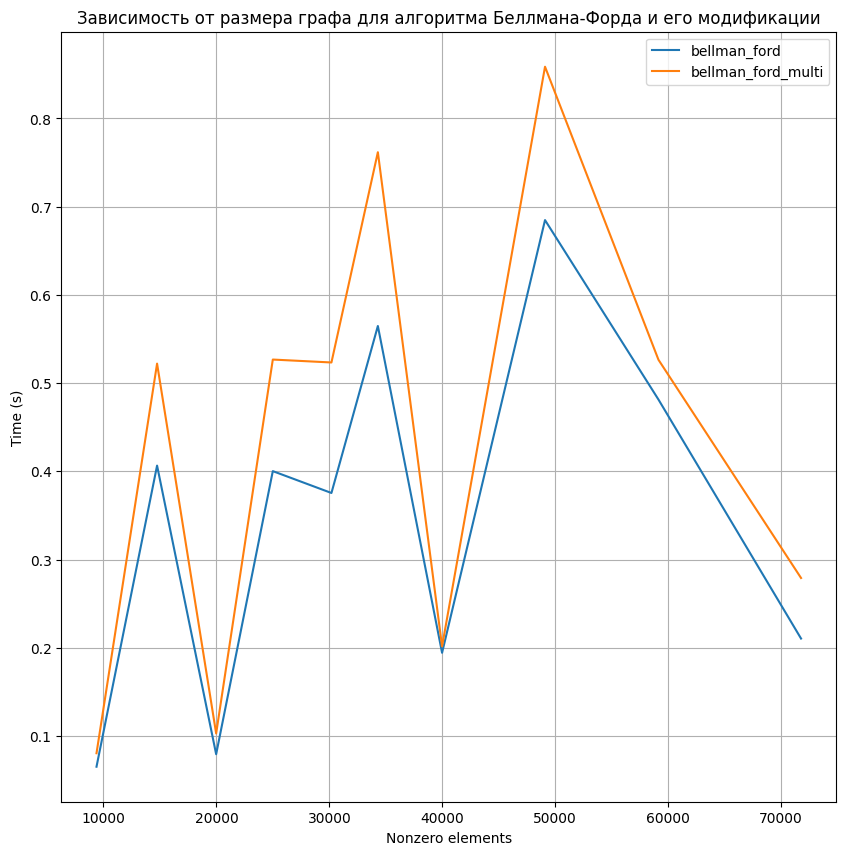

In [126]:
nonzero_count_list = list(results.keys())
time_1 = [results[count][0] for count in nonzero_count_list]
time_2 = [results[count][1] for count in nonzero_count_list]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(nonzero_count_list, time_1, label='bellman_ford')
ax.plot(nonzero_count_list, time_2, label='bellman_ford_multi')
ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('Зависимость от размера графа для алгоритма Беллмана-Форда и его модификации')
ax.legend()
ax.grid(True)

In [128]:
def calculate_time_floyd(A):
    start_time = time.time()
    floyd_warshall(A)
    time_1 = time.time() - start_time

    start_time = time.time()
    transitive_closure(A)
    time_2 = time.time() - start_time

    return time_1, time_2

In [135]:
from tqdm import tqdm_notebook as tqdm

**сравнение на сгененированных графах**

In [137]:
def generate_weighted_random_graph(num_vertices, sparsity, weight_range=(1, 10)):
    np_zeros = np.zeros((num_vertices, num_vertices))
    adjacency_matrix = gb.Matrix.from_dense(np_zeros, missing_value=0)

    for i in range(num_vertices):
        for j in range(i, num_vertices):
            if random.random() < sparsity:
                weight = random.randint(weight_range[0], weight_range[1])  # Генерация случайного веса
                if i == j:
                    adjacency_matrix[i, j] = weight  # Веса для петель
                else:
                    adjacency_matrix[i, j] = weight
                    adjacency_matrix[j, i] = weight  # Симметричное добавление веса

    return adjacency_matrix

In [ ]:
results_random = {}
for num_vertices in tqdm(np.arange(10, 200, 5)):
    graph = generate_weighted_random_graph(num_vertices, sparsity=0.1)
    times = calculate_time(graph)
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
time_1 = [results_random[count][0] for count in num_vertices_list]
time_2 = [results_random[count][1] for count in num_vertices_list]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, time_1, label='bellman_ford')
ax.plot(num_vertices_list, time_2, label='bellman_ford_multi')

ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('Зависимость от размера графа для алгоритма Беллмана-Форда и его модификации (степень разряженности = 0.1)')
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
results_random = {}
for num_vertices in tqdm(np.arange(10, 100, 5)):
    graph = generate_weighted_random_graph(num_vertices, sparsity=0.1)
    times = calculate_time_floyd(graph)
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
time_1 = [results_random[count][0] for count in num_vertices_list]
time_2 = [results_random[count][1] for count in num_vertices_list]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, time_1, label='Floyd–Warshall')
ax.plot(num_vertices_list, time_2, label='Транзитивное замыкание')

ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('Сравнение алгоритмов Флойда-Варшалла и транзитивного замыкания от размера графа (степень разряженности = 0.1)')
ax.legend()
ax.grid(True)
plt.show()

## Оценка push/pull direction optimization

In [144]:
def mod_bellman_ford(graph, start_vertex, flag_push=True):
    num_vertices = graph.nrows
    distances = Vector(dtypes.INT64, num_vertices)
    distances[start_vertex] << 0
    temp_distances = distances.dup()

    for iteration in range(num_vertices - 1):
        previous_distances = distances.dup()
        if flag_push:
            distances(binary.min) << distances.vxm(graph, semiring.min_plus)
        else:
            distances(binary.min) << graph.T.mxv(distances, semiring.min_plus)
        if distances.isequal(previous_distances):
            break

    result = []
    for index in range(num_vertices):
        result.append((index, float('inf') if distances[index].value is None or distances[index].value < 0 else distances[index].value))
    return result

In [146]:
def calculate_time_mod(A):
    start_time = time.time()
    mod_bellman_ford(A, 1, flag_push=True) # push
    time_1 = time.time() - start_time

    start_time = time.time()
    mod_bellman_ford(A, 1, flag_push=False) # pull
    time_2 = time.time() - start_time

    return time_1, time_2

In [ ]:
results_random = {}
for num_vertices in tqdm(np.arange(10, 300, 5)):
    graph = generate_weighted_random_graph(num_vertices, sparsity=0.1)
    times = calculate_time_mod(graph)
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
time_1 = [results_random[count][0] for count in num_vertices_list]
time_2 = [results_random[count][1] for count in num_vertices_list]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, time_1, label='bellman_ford (push)')
ax.plot(num_vertices_list, time_2, label='bellman_ford (pull)')

ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('Зависимость от размера графа для алгоритма Беллмана-Форда (push vs pull)')
ax.legend()
ax.grid(True)
plt.show()

**Вывод:**

*   Push и pull не отличается в производительности для алгоритма Беллмана-Форда
